In [2]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit
sys.path.append('..')
from external.NuOp.parallel_two_qubit_gate_decomposition import *
from external.NuOp.gates_numpy import cnot_gate, fsim_gate, cphase_gate, xy_gate, get_gate_unitary_qiskit, iswap, fsim
from itertools import product
from qiskit.transpiler import PassManager
import sys
from utils.riswap_gates.riswap import RiSwapGate
import h5py
#test

In [2]:
qc = QuantumCircuit(2)
from qiskit.quantum_info import random_unitary
qc.append(random_unitary(dims=(2,2)),[0,1])
qc.draw(output='mpl')

from qiskit.converters import circuit_to_dag, dag_to_circuit
dag = circuit_to_dag(qc)

In [3]:
base_fidelity = 1-5e-3
alpha_range = [2,3,5,7]
gate_range = range(2,9)
qc = QuantumCircuit(2)
from qiskit.circuit.library.standard_gates import SwapGate
qc.append(SwapGate(), [0,1])
dag = circuit_to_dag(qc)

In [4]:
#don't change, would break previous data collection
#XXX
alpha_range = [2,3,5,7]#,11]
gate_range = range(2,9)

def collect_random2q_data(base_fidelity):
    base_fidelity = base_fidelity
    empty_flag = 0
    N=20

    #load in previous data
    with h5py.File('data/data.h5', 'r') as h5f:
        try:
            #gate_error = h5f['random2q_gate_error'][:]
            decomp_error = h5f['random2q_decomp_error'][:]
            #fidelity_error = h5f['random2q_fidelity_error'][:]

            #backfill data
            gate_error = np.zeros(shape=(len(decomp_error), len(alpha_range), len(gate_range)))
            fidelity_error = np.zeros(shape=(len(decomp_error), len(alpha_range), len(gate_range)))
            for i in range(len(decomp_error)):
                for alpha_index, alpha in enumerate(alpha_range):
                    alpha = 1/alpha
                    for gate_index, gate_count in enumerate(gate_range):
                        gate_error[i][alpha_index][gate_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
                        fidelity_error[i][alpha_index][gate_index] = (decomp_error[i][alpha_index][gate_index])*gate_error[i][alpha_index][gate_index]

        except Exception:
            #case where data doesn't already exist
            empty_flag = 1

    for n in range(N-len(decomp_error)):

        # if not empty_flag and len(gate_error) >= N:
        #     break

        qc = QuantumCircuit(2)
        from qiskit.quantum_info import random_unitary
        qc.append(random_unitary(dims=(2,2)),[0,1])
        dag = circuit_to_dag(qc)

        #new data for this iteration
        temp_gate_error = np.zeros(shape=(1, len(alpha_range), len(gate_range)))
        temp_decomp_error = np.zeros(shape=(1, len(alpha_range), len(gate_range)))
        temp_fidelity_error = np.zeros(shape=(1, len(alpha_range), len(gate_range)))

        for alpha_index, alpha in enumerate(alpha_range):
            alpha = 1/alpha
            for gate_index, gate_count in enumerate(gate_range):

                params = [[alpha]]
                gate_labels = [f'$iSwap^{alpha}$']
                gate_defs = [RiSwapGate]

                temp_gate_error[0][alpha_index][gate_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
            
                #run perfect if it doesn't already exist
                fid_2q = {(0,1):[1]}
                pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
                approx = pgrp.run(dag)
                temp_decomp_error[0][alpha_index][gate_index] = (pgrp.property_set["best_fid"])
                temp_fidelity_error[0][alpha_index][gate_index] = (temp_gate_error[0][alpha_index][gate_index])*temp_decomp_error[0][alpha_index][gate_index]

                #run noisy
                # fid_2q = {(0,1):[1-alpha*(1-base_fidelity)]}
                # pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
                # approx = pgrp.run(dag)
                # temp_fidelity_error[0][alpha_index][gate_index] = (pgrp.property_set["best_fid"])

                #these are equivalent - save some time and just calculate it using the previous values
                
                # print(f"{gate_error[-1]}, {decomp_error[-1]}, {fidelity_error[-1]}")

        #update data

        if empty_flag:
            gate_error = temp_gate_error
            decomp_error = temp_decomp_error
            fidelity_error = temp_fidelity_error
            empty_flag = 0
        else:
            gate_error = np.append(gate_error, temp_gate_error, axis=0)
            decomp_error = np.append(decomp_error, temp_decomp_error, axis=0)
            fidelity_error = np.append(fidelity_error, temp_fidelity_error, axis=0)

        #write back data after each iteration in case we end early
        with h5py.File('data/data.h5', 'r+') as h5f:
            print(f"saving iter {n}")
            # delete old, differently sized dataset
            try:
                del h5f['random2q_gate_error'] 
                del h5f['random2q_decomp_error']
                del h5f['random2q_fidelity_error']
            except Exception:
                #don't need to delete if they don't exist
                pass
            h5f.create_dataset('random2q_gate_error', data=gate_error)
            h5f.create_dataset('random2q_decomp_error', data=decomp_error)
            h5f.create_dataset('random2q_fidelity_error', data=fidelity_error)
            
    return gate_error, decomp_error, fidelity_error

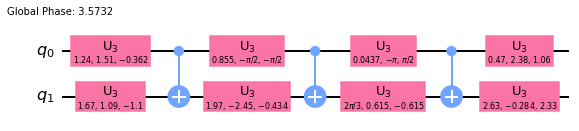

In [4]:
qc = QuantumCircuit(2)
from qiskit.quantum_info import random_unitary
qc.append(random_unitary(dims=(2,2)),[0,1])
dag = circuit_to_dag(qc)
qc.decompose().draw(output='mpl')

0.9999999998025767


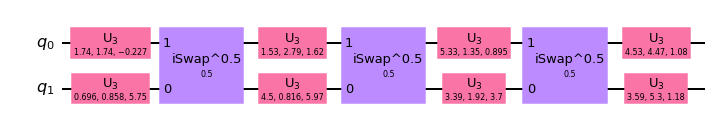

In [10]:
alpha = 1/2
gate_count = 3
params = [[alpha]]
gate_labels = [f'$iSwap^{alpha}$']
gate_defs = [RiSwapGate]
#temp_gate_error[0][alpha_index][gate_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
#run perfect if it doesn't already exist
fid_2q = {(0,1):[1]}
pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
approx = pgrp.run(dag)
from qiskit.converters import dag_to_circuit
print(pgrp.property_set["best_fid"])
dag_to_circuit(approx).draw(output='mpl')

In [ ]:
# alpha = 1/2
# gate_count = 3
# params = [[alpha]]
# gate_labels = [f'$iSwap^{alpha}$']
# gate_defs = [RiSwapGate]
# #temp_gate_error[0][alpha_index][gate_index] = ((1-(alpha*(1-base_fidelity)))**gate_count)
# #run perfect if it doesn't already exist
# fid_2q = {(0,1):[1]}
# pgrp = ParallelGateReplacementPass(gate_defs, params ,fid_2q, fidelity_list_1q_gate=[1 for _ in range(54)], tol=1e-10, force_gate_count=gate_count)
# approx = pgrp.run(dag)
# from qiskit.converters import dag_to_circuit
# print(pgrp.property_set["best_fid"])
# dag_to_circuit(approx).draw(output='mpl')

In [5]:
from scipy.stats import sem
# import h5py
# with h5py.File('data.h5', 'r') as h5f:
#     gate_error = h5f['random2q_gate_error'][:]
#     decomp_error = h5f['random2q_decomp_error'][:]
#     fidelity_error = h5f['random2q_fidelity_error'][:]

import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])

def create_plot(gate_error, decomp_error, fidelity_error):
    fig, axs = plt.subplots(1,len(gate_error[0]), sharey=True, figsize=(12, 4))
    for alpha_index in range(len(gate_error[0])):
        alpha = 1/alpha_range[alpha_index]
        gate_unit_time = [el*alpha for el in gate_range]
        axs[alpha_index].plot(gate_unit_time, np.average(gate_error, axis=0)[alpha_index], label="Gate Error", linestyle='--', marker='o')
        axs[alpha_index].errorbar(gate_unit_time, np.average(decomp_error, axis=0)[alpha_index], yerr=sem(decomp_error, axis=0)[alpha_index], label="Decomp Error", linestyle='--', marker='s')
        axs[alpha_index].errorbar(gate_unit_time, np.average(fidelity_error, axis=0)[alpha_index], yerr=sem(fidelity_error, axis=0)[alpha_index], label="Total Fidelity", marker='^')
        axs[alpha_index].set_xlabel("Gate Unit Time")
        axs[alpha_index].set_title(f"iSwap^(1/{1/alpha})")
    # for i, key in enumerate(np.max(np.average(fidelity_error, axis=0),axis=1)):
    #     axs[i].annotate(key, (i, frequency_list[key]))
    #     if i >= 3:
    #         break

    axs[-1].legend()
    axs[0].set_ylabel("Avg Fidelity")
    axs[0].set_yscale('logit')
    fig.tight_layout()
    fig.show()
    filename = "nuop_experiment"
    fig.savefig('{}.pdf'.format(filename), format="pdf", facecolor='white')

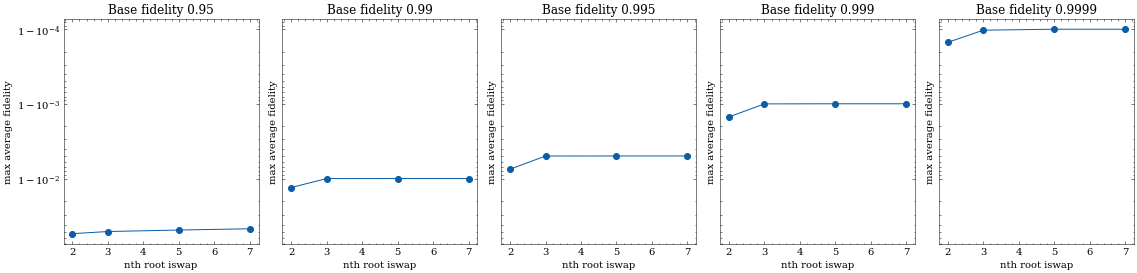

In [6]:
base_fidelity_list = [1-5e-2, 1-10e-3,1-5e-3, 1-10e-4, 1-10e-5]
fig, axs = plt.subplots(1, len(base_fidelity_list), sharey=True, figsize=(16, 4))
for ax, bf in zip(axs, base_fidelity_list):
    gate_error, decomp_error, fidelity_error = collect_random2q_data(bf)
    ax.plot(alpha_range, np.max(np.average(fidelity_error, axis=0),axis=1), '-o')
    ax.set_xlabel("nth root iswap")
    ax.set_ylabel("max average fidelity")
    ax.set_title(f"Base fidelity {bf}")
    ax.set_yscale('logit')
    
fig.tight_layout()

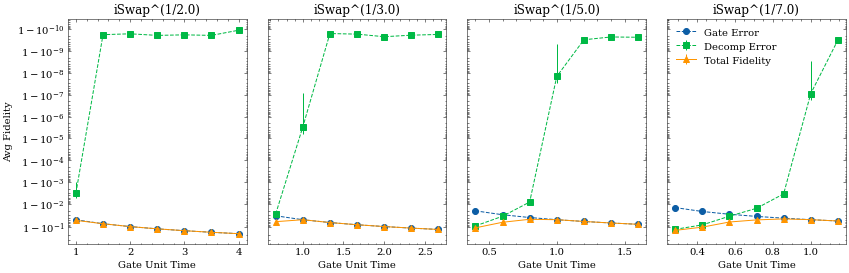

In [32]:
gate_error, decomp_error, fidelity_error = collect_random2q_data(1-5e-2)
create_plot(gate_error, decomp_error, fidelity_error)